<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/KAIST_SDL_1_Generative_AI_DDIM%2BcDDIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Generative AI: Denoising Diffusion Implicit Models (DDIM)**

![DDIM](https://drive.google.com/uc?id=10IVOM5qJYd9N3KTEgd7IPhnS0R9TM_tB)
**Overview**:  

1) Import libraries and set up environment.  
2) Define parameters.  
3) Load and preprocess data.  
4) Initialize model and scheduler.  
5) Run the training loop.  
6) Visualize and analyze results.  


## 1) Import Libraries and Environment Setup

### **| Load dataset & Pre-trained model**


In [1]:
!gdown 1TLpSJW9X9d1l6-3HKbRiLYGqY12RDDju -O dataset.zip
!unzip -q dataset.zip -d ./dataset_56x56_36
!ls ./dataset_56x56_36

# Pre-trained 모델
!gdown 1ZjH4sgYuOREx9sKJk0O3ARckcjVycD1D -O Generator_DDIM.pth
!ls -lh Generator_DDIM.pth

!gdown 1VgQzcvOy7PNUIgkImjZrKOToYYB9xqlI -O Generator_cDDIM.pth
!ls -lh Generator_cDDIM.pth

Downloading...
From: https://drive.google.com/uc?id=1TLpSJW9X9d1l6-3HKbRiLYGqY12RDDju
To: /content/dataset.zip
100% 41.0k/41.0k [00:00<00:00, 68.1MB/s]
10.png	14.png	18.png	21.png	25.png	29.png	32.png	36.png	6.png
11.png	15.png	19.png	22.png	26.png	2.png	33.png	3.png	7.png
12.png	16.png	1.png	23.png	27.png	30.png	34.png	4.png	8.png
13.png	17.png	20.png	24.png	28.png	31.png	35.png	5.png	9.png
Downloading...
From (original): https://drive.google.com/uc?id=1ZjH4sgYuOREx9sKJk0O3ARckcjVycD1D
From (redirected): https://drive.google.com/uc?id=1ZjH4sgYuOREx9sKJk0O3ARckcjVycD1D&confirm=t&uuid=1a9c3894-91c9-426e-a329-50639af38793
To: /content/Generator_DDIM.pth
100% 176M/176M [00:01<00:00, 94.5MB/s]
-rw-r--r-- 1 root root 168M Feb 22 15:14 Generator_DDIM.pth
Downloading...
From (original): https://drive.google.com/uc?id=1VgQzcvOy7PNUIgkImjZrKOToYYB9xqlI
From (redirected): https://drive.google.com/uc?id=1VgQzcvOy7PNUIgkImjZrKOToYYB9xqlI&confirm=t&uuid=e1e25b50-ec05-4a2c-b94f-bd33dd0d46e0
To: /con

### **| Import python libraries and define util functions**


In [2]:
!pip install --upgrade diffusers[torch]

In [3]:
# - 입력(x)과 라벨(y)의 형태(shape)와 범위(range)를 먼저 확인
# - 재현성을 위해 seed 고정, device(CPU/GPU) 설정

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
from diffusers import UNet2DModel, DDIMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from PIL import Image, ImageDraw, ImageFont

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
import torchvision.transforms as T

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", device)

def set_seed(seed=42):
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def img_read(src, file):
    """Read grayscale image as a NumPy array."""
    img = cv.imread(os.path.join(src, file), cv.IMREAD_GRAYSCALE)
    return img


def show_img(images_list,
             r=1,
             cmap='gray',
             img_size=(5, 5),
             axis="off",
             colorbar=False,
             colorbar_range=None,
             save_path=None):
    if r < 1:
        r = 1

    total_images = len(images_list)
    if total_images == 0:
        print("No images to display.")
        return

    cols = (total_images + r - 1) // r
    fig, axs = plt.subplots(r, cols, figsize=(cols * img_size[0], r * img_size[1]))

    if r == 1:
        axs = axs.reshape(1, -1)

    for idx, item in enumerate(images_list):
        ax = axs[0, idx] if r == 1 else axs[idx // cols, idx % cols]
        im = None
        if isinstance(item, Image.Image):
            if item.mode in ['L', '1']:  # Grayscale images
                im = ax.imshow(item, cmap=cmap)
            else:  # Color images
                im = ax.imshow(item)
        elif isinstance(item, np.ndarray):
            if item.ndim == 2:  # 2D array, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D array, color image
                im = ax.imshow(item, cmap=cmap if item.shape[-1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D array with batch dimension of 1
                im = ax.imshow(item[0], cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported numpy array shape: {item.shape}.")
        elif torch.is_tensor(item):
            item = item.detach().cpu().numpy()
            if item.ndim == 2:  # 2D tensor, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D tensor, color image
                im = ax.imshow(item.transpose(1, 2, 0), cmap=cmap if item.shape[0] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D tensor with batch dimension of 1
                im = ax.imshow(item[0].transpose(1, 2, 0), cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported torch tensor shape: {item.shape}.")
        else:
            raise ValueError("Unsupported image type. Supported types: PIL Image, numpy array, torch tensor.")

        if colorbar and im is not None:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(im, cax=cax)

        ax.axis(axis)

    plt.tight_layout()
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def show_img_subplot(images_list, r=6, c=6, cmap='gray', img_size=(2, 2), axis="off", colorbar=False, colorbar_range=None, save_path=None):
    """Display multiple images in a 6x6 grid."""
    total_images = len(images_list)
    fig, axs = plt.subplots(r, c, figsize=(c * img_size[0] * 0.6, r * img_size[1] * 0.6))

    for idx, item in enumerate(images_list[:r * c]):
        ax = axs[idx // c, idx % c]
        if torch.is_tensor(item):
            item = item.detach().cpu().numpy()

        if item.ndim == 2:
            im = ax.imshow(item, cmap=cmap,
                           vmin=colorbar_range[0] if colorbar_range else None,
                           vmax=colorbar_range[1] if colorbar_range else None)
        elif item.ndim == 3:
            if item.shape[0] < 10:
                item = np.transpose(item, (1, 2, 0))
            im = ax.imshow(item, cmap=cmap,
                           vmin=colorbar_range[0] if colorbar_range else None,
                           vmax=colorbar_range[1] if colorbar_range else None)
        else:
            raise ValueError(f"Unsupported shape: {item.shape}")

        ax.axis(axis)

    plt.tight_layout()
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def get_data():
    """Load images and normalize."""
    img_files = [f for f in os.listdir(src) if f.endswith('.png')]
    images = []

    for file in img_files[:36]:  # Load only 36 images
        index_str = os.path.splitext(file)[0]
        try:
            _ = int(index_str)
        except ValueError:
            continue
        img = img_read(src, file)
        img_t = T.Compose([
            T.ToPILImage(mode='L'),
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5])
        ])(img)
        images.append(img_t.numpy())

    images = np.array(images)
    return images



Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Torch version: 2.10.0+cu128
CUDA available: True
Device: cuda:0


## 2) Define Parameters

In [4]:
batch_size = 128
comp = 'DDIM'
eta = 0.0  # DDIM parameter
seed = 0
set_seed(seed)

NUM_NODES = 57
IMG_H, IMG_W = 56, 56

src = './dataset_56x56_36/'

print("Batch size:", batch_size)
print("Image size:", (IMG_H, IMG_W))
print("Seed:", seed)

Batch size: 128
Image size: (56, 56)
Seed: 0


## 3) Load and Preprocess Data

Train images shape: torch.Size([36, 1, 56, 56])


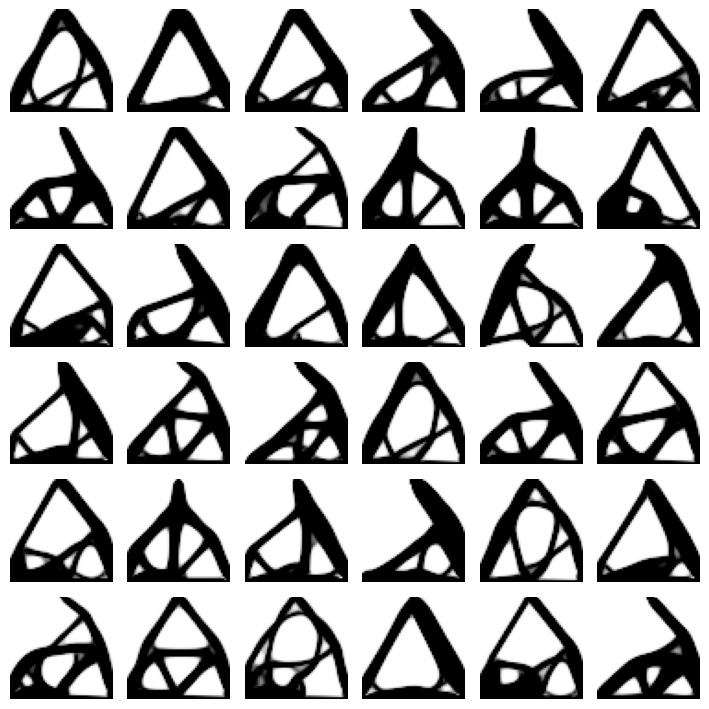

In [5]:
# 불러오기 and convert to tensors
train_images = torch.tensor(get_data(), dtype=torch.float32)

print("Train images shape:", train_images.shape)

# 시각화 loaded images
show_img_subplot(train_images[:36], r=6, c=6)

## 4) Initialize Model and Scheduler
We create a `UNet2DModel` to predict noise and a `DDIMScheduler` to handle noise scheduling. We also set up our DataLoaders, optimizer, and LR scheduler.

### **| Image Denoising Process**

Use UNet and the DDIM Noise Scheduler to implement a progressive restoration of noisy images. Guide codes are available at [Hugging Face DDIM Pipeline] (https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddim/pipeline_ddim.py).

In [6]:
# UNet 모델
unet = UNet2DModel(
    sample_size=56,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=[64, 128, 256, 512],
).to(device)


It receives `noisy_images` and `timestep` as inputs and outputs the predicted noise.

torch.Size([4, 1, 56, 56])


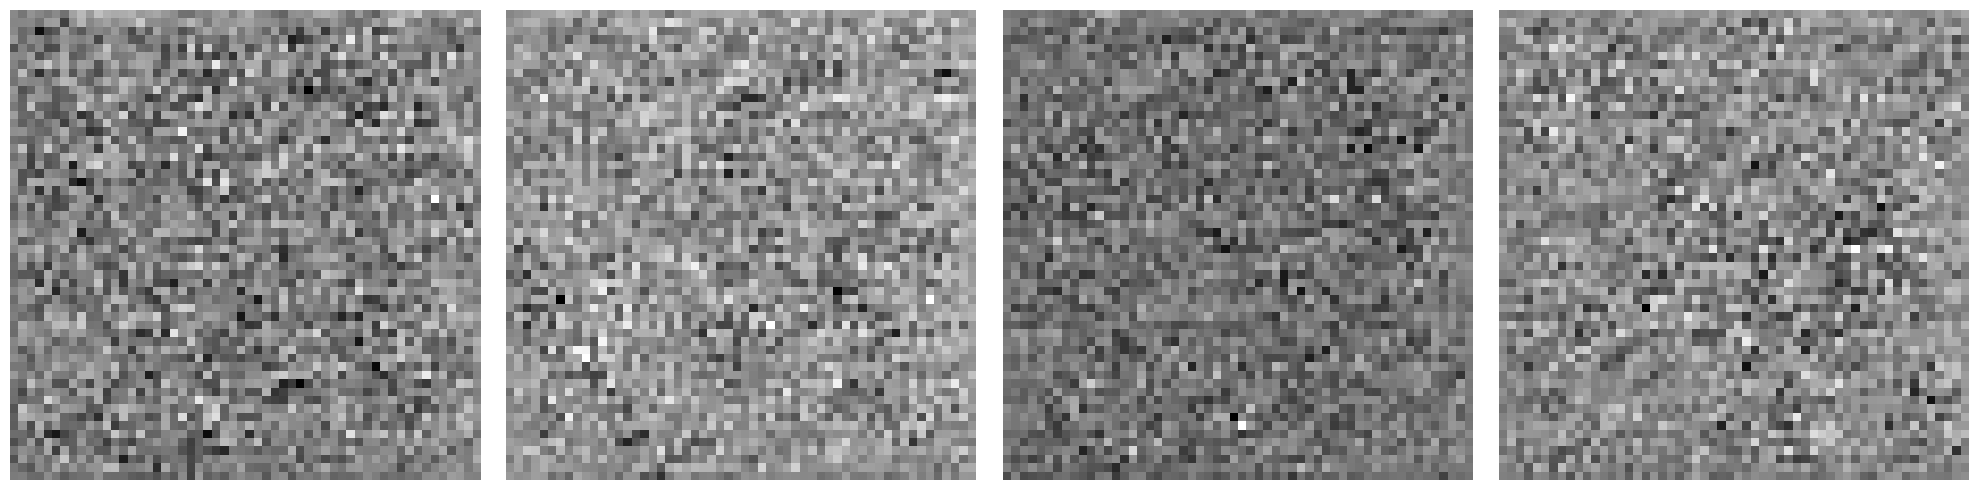

In [7]:
# - train 단계: model.train(), grad 계산 O, optimizer.step()
# - eval 단계: model.eval(), torch.no_grad(), metric만 계산

noisy_images = torch.randn((4, 1, 56, 56)).to(device)
timestep = torch.tensor([10]).to(device)
with torch.no_grad():
    pred_noises = unet(noisy_images, timestep).sample
print(pred_noises.shape)
show_img(pred_noises)

### **| Noise scheduler**

In [8]:
noise_scheduler = DDIMScheduler(num_train_timesteps=600)
noise_scheduler.set_timesteps(5) # noise scheduler timesteps set up
print('timesteps : ', len(noise_scheduler.timesteps), noise_scheduler.timesteps) # check the timesteps

timesteps :  5 tensor([480, 360, 240, 120,   0])


tensor(480)


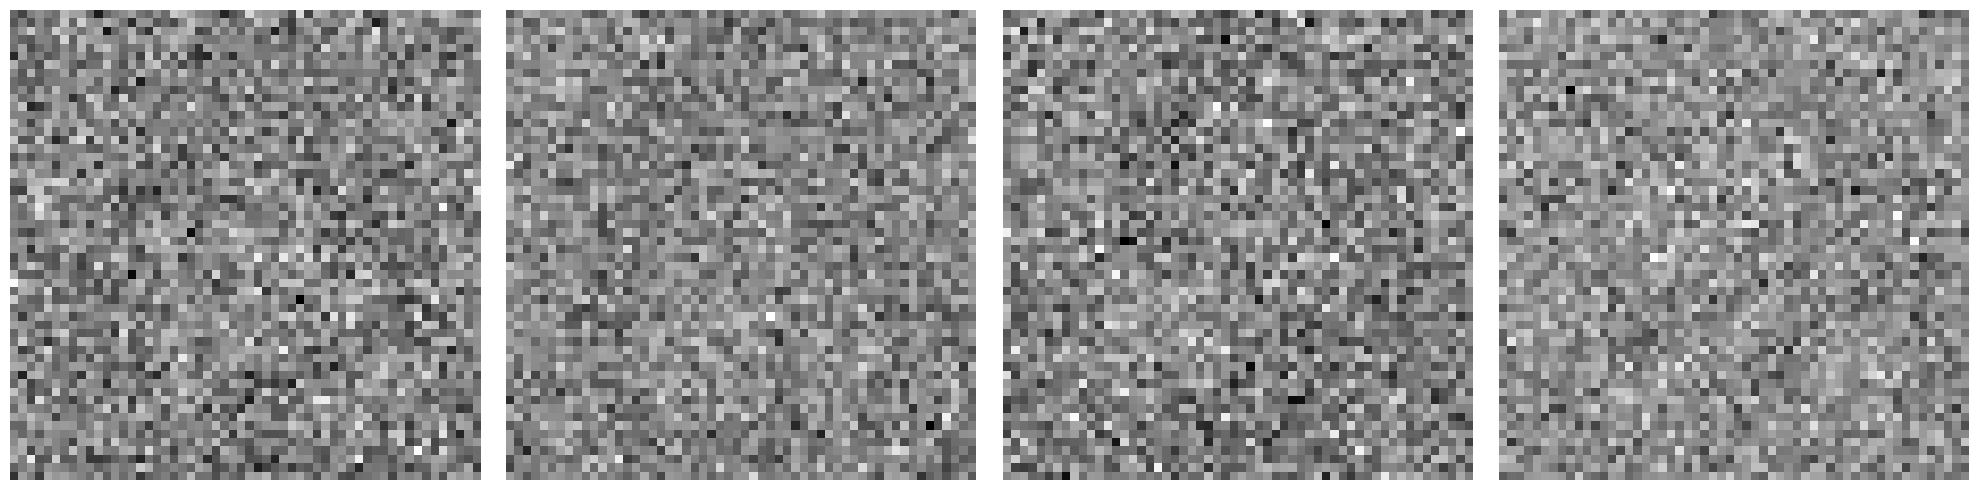

tensor(360)


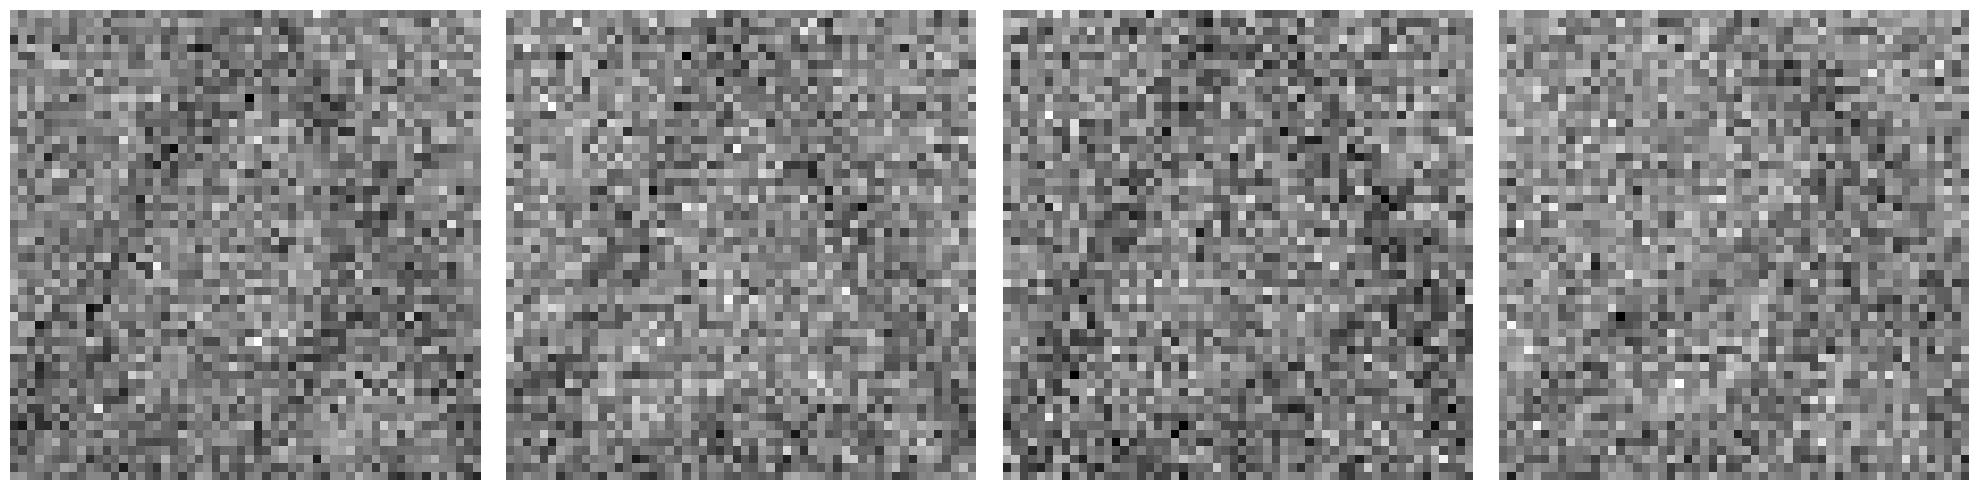

tensor(240)


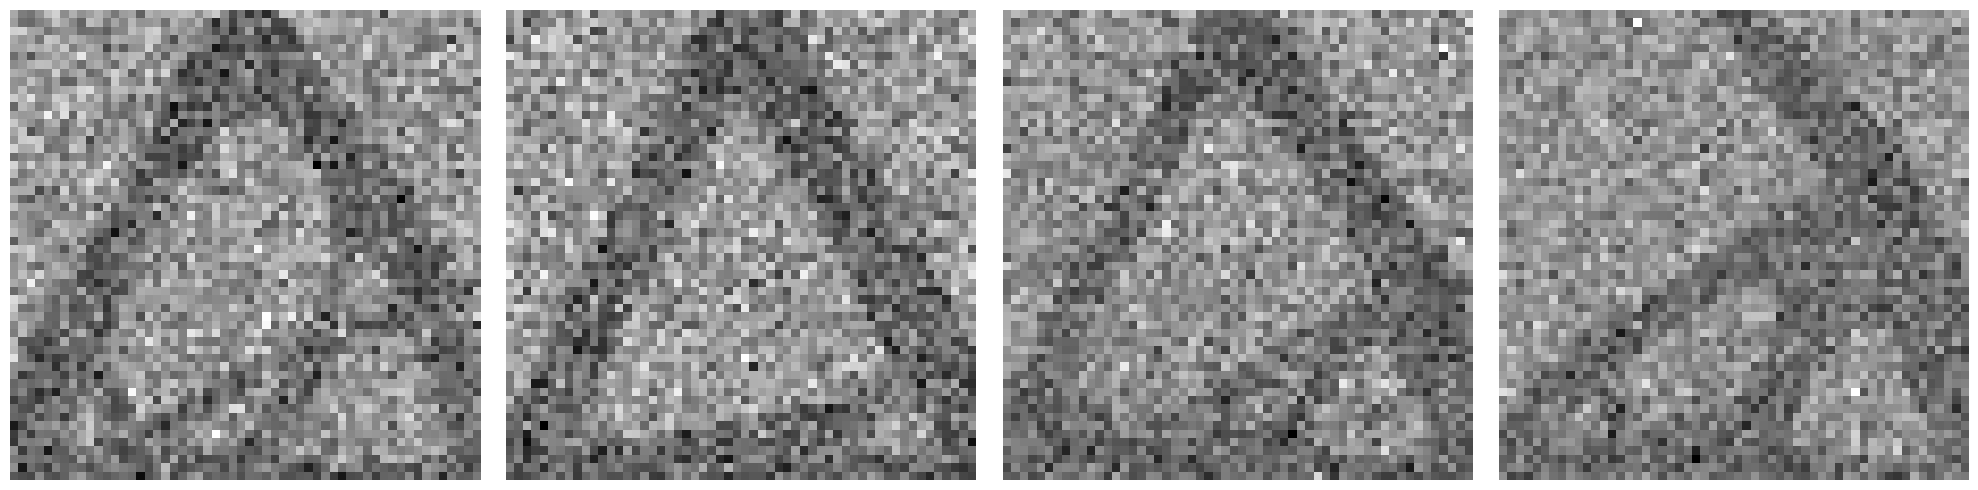

tensor(120)


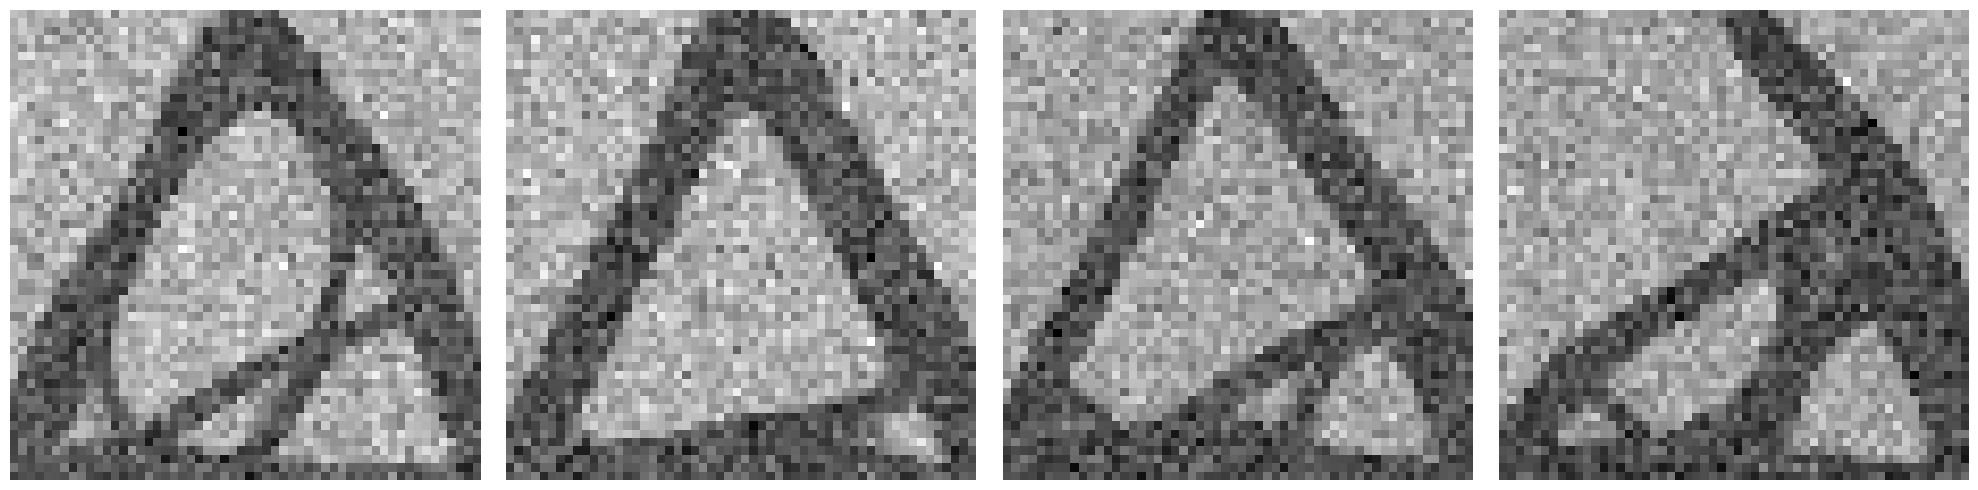

tensor(0)


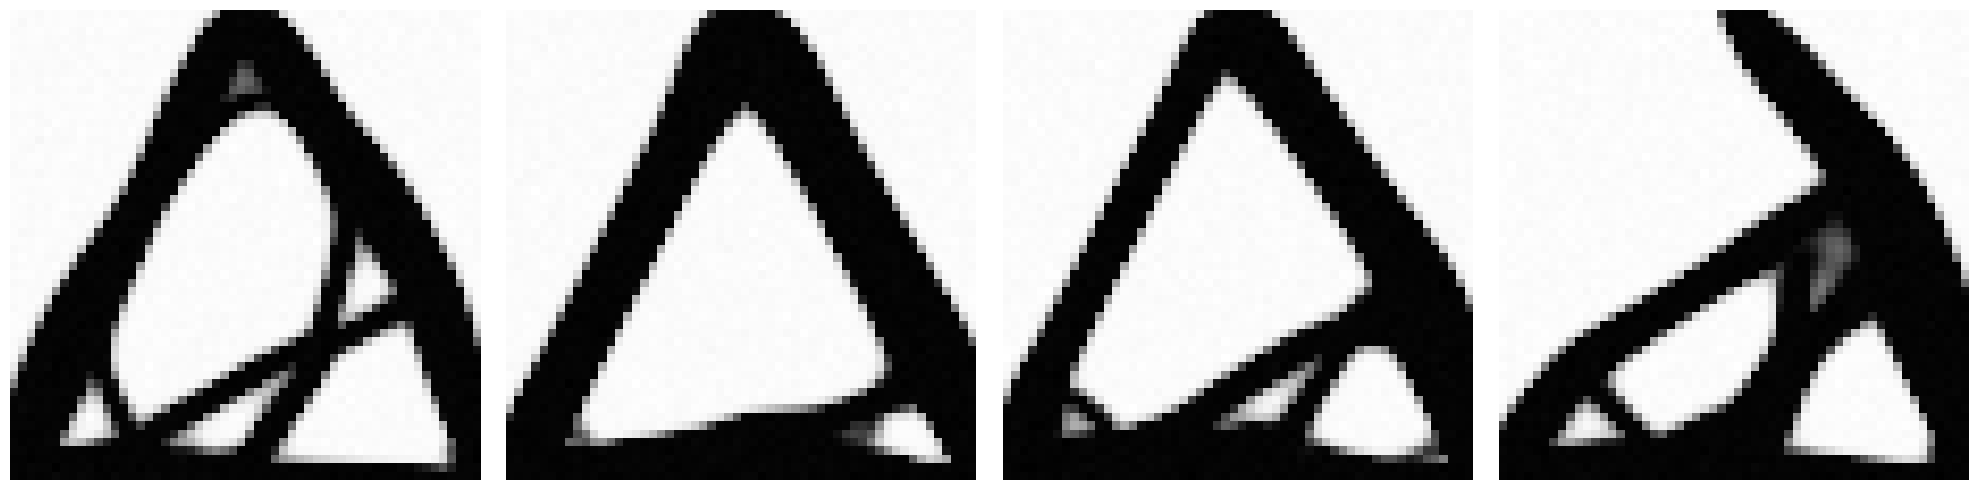

In [9]:
images = train_images[:4].to(device)
for timestep in noise_scheduler.timesteps:
    print(timestep)

    noises = torch.randn(images.shape).to(device)
    noisy_images = noise_scheduler.add_noise(images, noises, timestep)
    show_img(noisy_images)

### **| Image Denoising Process**

Use UNet and the DDIM Noise Scheduler to implement a progressive restoration of noisy images. Guide codes are available at [Hugging Face DDIM Pipeline] (https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddim/pipeline_ddim.py).

(4, 1, 56, 56)


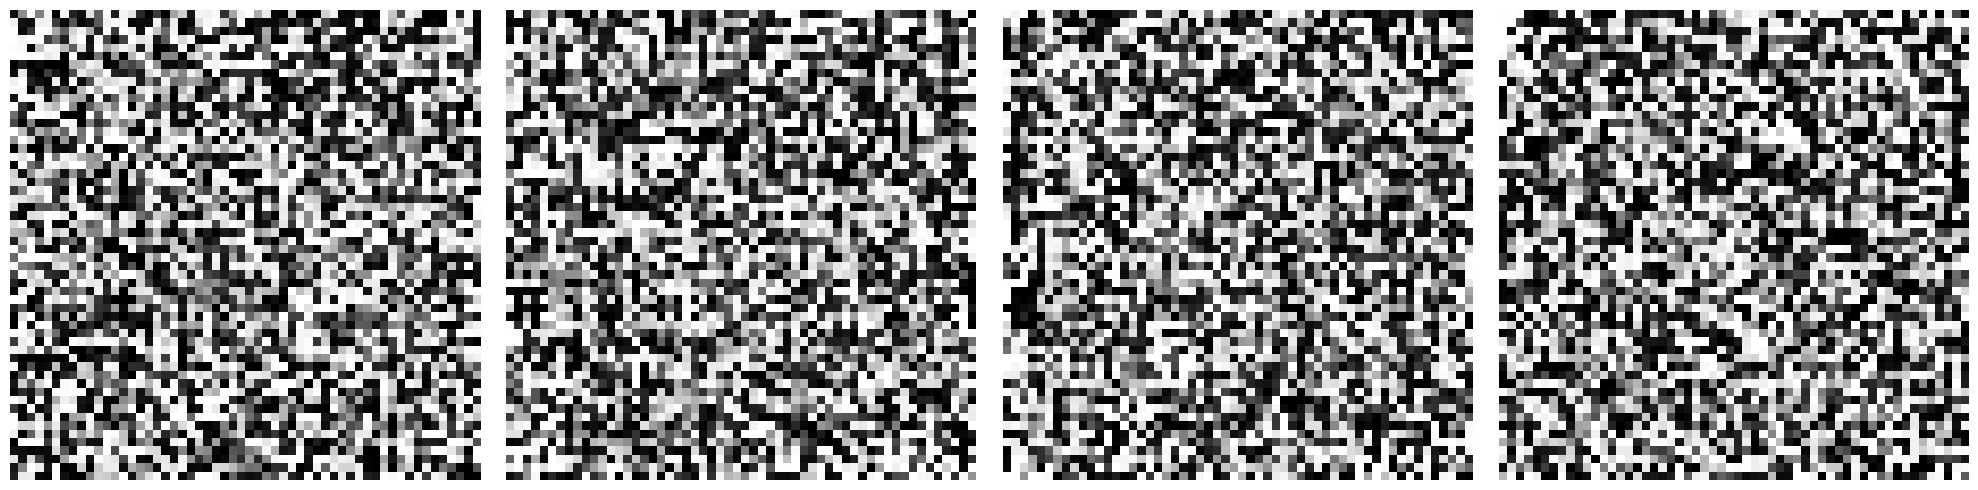

In [10]:
noise_scheduler.set_timesteps(4) # set up the num of inference steps
images =  torch.randn((4, 1, 56, 56)).to(device) # set up initial noise
for timestep in noise_scheduler.timesteps: # Repeat as many times as timesteps

    with torch.no_grad(): # deactivate gradient calculation
        pred_noises = unet(images, timestep).sample # UNet pipeline
        images  = noise_scheduler.step(pred_noises, timestep, images).prev_sample # denoising step

images = images.cpu().detach().numpy()
print(images.shape)
show_img(images[:,0])

### **| Defining the Diffusion Model**

In [11]:
# 학습 hyperparameters
num_train_timesteps = 600
num_inference_steps = 50
num_epochs = 20
lr_warmup_steps = 100
learning_rate = 1e-4
max_norm = 1  # gradient clipping threshold
n = 10        # number of images to sample during evaluation

# DDIM scheduler
noise_scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps)

# 생성 데이터셋/loader
train_dataset = TensorDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Optimizer and LR scheduler
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=(len(train_dataset) * num_epochs),
)

output_dir = './'
os.makedirs(output_dir, exist_ok=True)
print("Model, scheduler, optimizer, and DataLoader are set.")


Model, scheduler, optimizer, and DataLoader are set.


## 5) Training Loop
1. Add random noise to images based on a random timestep.
2. Predict the noise using UNet.
3. Compute loss and backprop.
4. Validate with a test set.
5. Save best models.
6. Periodically sample and save generated images.

In [12]:
start_time = time.time()
best_train_loss = float("inf")
loss_history = {"train_loss": []}

for epoch in range(num_epochs):
    epoch_start = time.time()
    unet.train()
    total_loss = 0.0

    # 학습
    for step, imgs in enumerate(train_loader):
        imgs = imgs[0].to(device)
        optimizer.zero_grad()

        # 1) Add 노이즈
        noise = torch.randn_like(imgs)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                  (imgs.shape[0],), device=device).long()
        noisy_images = noise_scheduler.add_noise(imgs, noise, timesteps)

        # 2) UNet forward
        noise_pred = unet(noisy_images, timesteps).sample

        # 3) Compute 손실
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm)
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()

    average_loss_train = total_loss / len(train_loader)
    loss_history["train_loss"].append(average_loss_train)

    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {average_loss_train:.6f} | Time: {epoch_duration:.2f}s")


Epoch 1/20 | Train Loss: 1.094945 | Time: 1.61s
Epoch 2/20 | Train Loss: 1.087165 | Time: 0.66s
Epoch 3/20 | Train Loss: 1.081223 | Time: 0.67s
Epoch 4/20 | Train Loss: 1.076348 | Time: 0.68s
Epoch 5/20 | Train Loss: 1.054279 | Time: 0.69s
Epoch 6/20 | Train Loss: 1.040625 | Time: 0.68s
Epoch 7/20 | Train Loss: 1.015447 | Time: 0.69s
Epoch 8/20 | Train Loss: 0.993486 | Time: 0.68s
Epoch 9/20 | Train Loss: 0.977162 | Time: 0.67s
Epoch 10/20 | Train Loss: 0.959037 | Time: 0.67s
Epoch 11/20 | Train Loss: 0.925064 | Time: 0.68s
Epoch 12/20 | Train Loss: 0.904288 | Time: 0.69s
Epoch 13/20 | Train Loss: 0.871159 | Time: 0.67s
Epoch 14/20 | Train Loss: 0.844683 | Time: 0.67s
Epoch 15/20 | Train Loss: 0.807876 | Time: 0.65s
Epoch 16/20 | Train Loss: 0.782692 | Time: 0.67s
Epoch 17/20 | Train Loss: 0.767181 | Time: 0.67s
Epoch 18/20 | Train Loss: 0.714995 | Time: 0.67s
Epoch 19/20 | Train Loss: 0.701631 | Time: 0.67s
Epoch 20/20 | Train Loss: 0.665682 | Time: 0.68s


## 6) Image generation (inference)

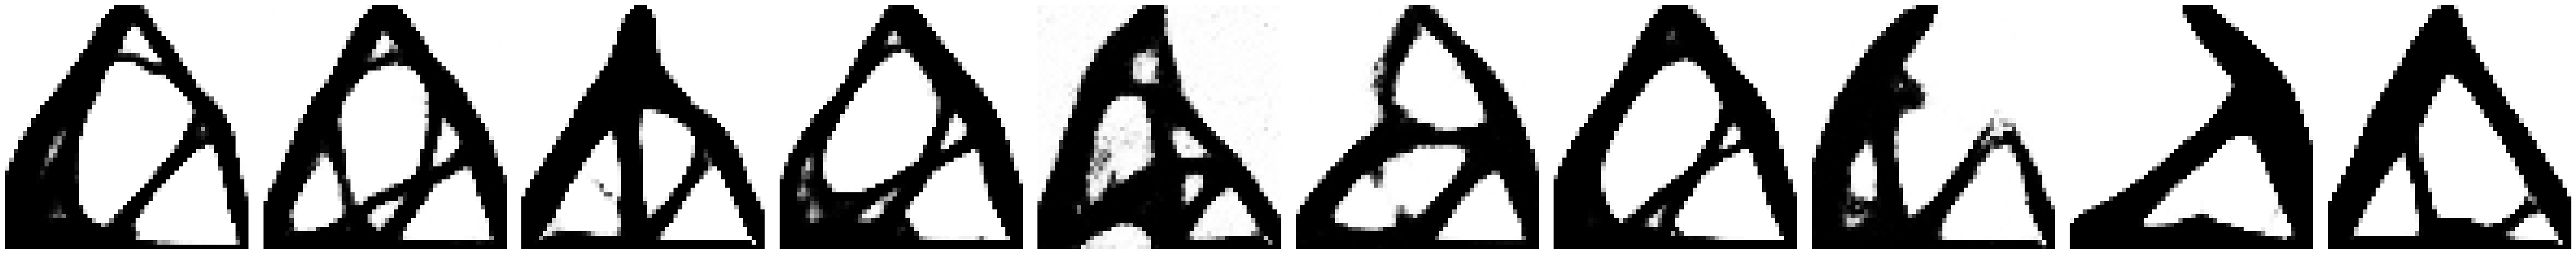

In [13]:
# Sigmoid filter for post-processing
def sigmoid_filter(img, threshold=0.0, alpha=10.0):
    return torch.sigmoid(alpha * (img - threshold))

unet.load_state_dict(torch.load("Generator_DDIM.pth", map_location=device))
unet.eval()

num_inference_steps = 50
noise_scheduler.set_timesteps(num_inference_steps)

images = torch.randn((10, 1, 56, 56)).to(device)

for timestep in noise_scheduler.timesteps:
    with torch.no_grad():
        pred_noises = unet(images, timestep).sample
    images = noise_scheduler.step(pred_noises, timestep.long(), images).prev_sample

images = sigmoid_filter(images, threshold=0.0, alpha=10.0)
show_img(images.cpu().detach().numpy()[:, 0])

Generating images...
Generating image 10/100...
Generating image 20/100...
Generating image 30/100...
Generating image 40/100...
Generating image 50/100...
Generating image 60/100...
Generating image 70/100...
Generating image 80/100...
Generating image 90/100...
Generating image 100/100...
Image generation completed. 100 images saved to ./DDIM_Generated_images


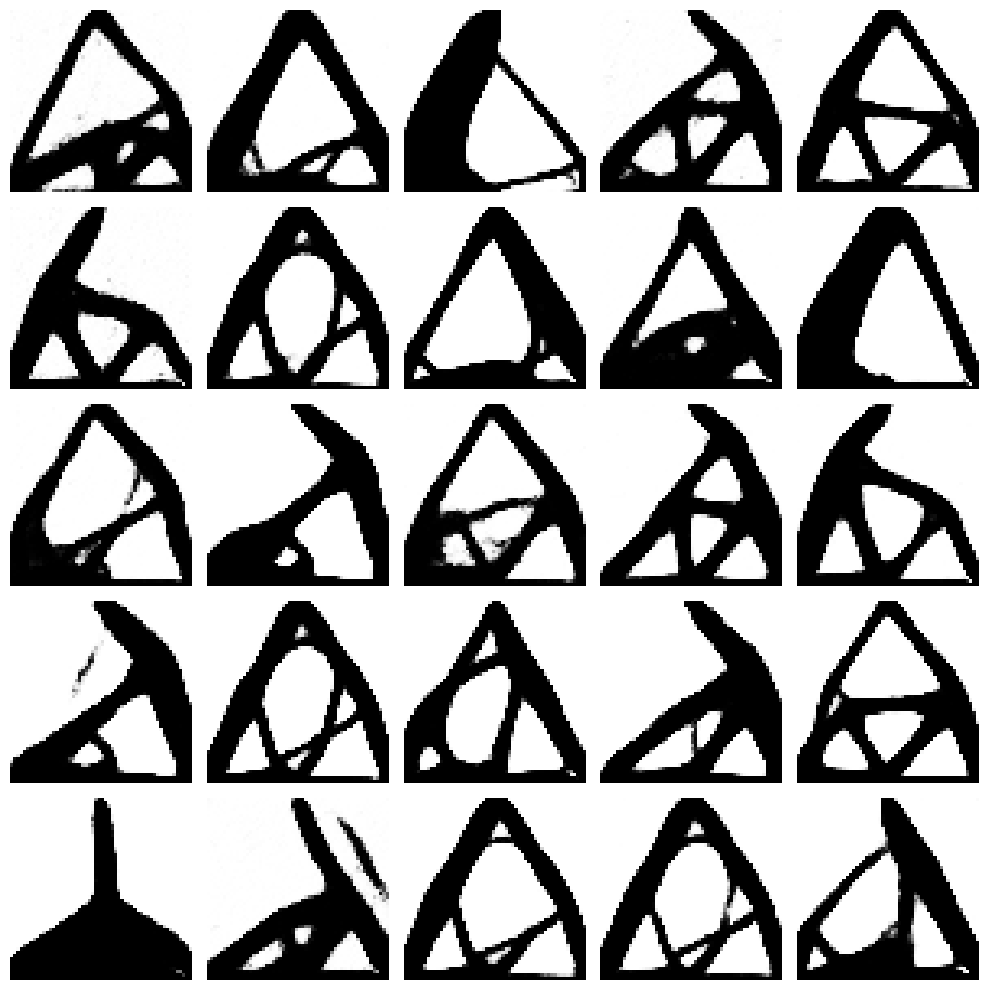

In [14]:
num_images = 100  # Number of images to generate

# Output directory
output_dir = "./DDIM_Generated_images"
os.makedirs(output_dir, exist_ok=True)

# 초기화 DDIM 스케줄러
noise_scheduler.set_timesteps(num_inference_steps, eta)

# Set seed for reproducibility
generator = torch.manual_seed(0)

# 생성 images
print("Generating images...")
generated_images = []
for i in range(1, num_images + 1):
    if i % 10 == 0:
        print(f"Generating image {i}/{num_images}...")

    # 생성 random 노이즈
    images = torch.randn((1, 1, 56, 56), generator=generator).to(device)

    # DDIM 추론 (denoising step)
    for timestep in noise_scheduler.timesteps:
        with torch.no_grad():
            pred_noises = unet(images, timestep).sample
        images = noise_scheduler.step(pred_noises, timestep.long(), images).prev_sample

    # Apply sigmoid filter
    images = sigmoid_filter(images, threshold=0.0, alpha=10.0)

    # 저장 generated image
    image_path = os.path.join(output_dir, f"inference_{i:03d}.png")
    save_image(images, image_path, normalize=True)

    # Store for visualization
    generated_images.append(images.cpu().detach().numpy()[0, 0])

print(f"Image generation completed. {num_images} images saved to {output_dir}")

# 시각화 generated images
def show_generated_images(images, rows=5, cols=5):
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axs.flatten()):
        if i >= len(images):
            break
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 출력/시각화 the first 25 generated images
show_generated_images(generated_images, rows=5, cols=5)

## 7) Data labeling
![FEA](https://drive.google.com/uc?id=1aGEcPzFiDNKJJZVfqOltpFffu8POBj3G)

(Andreassen, E., Clausen, A., Schevenels, M., Lazarov, B. S., & Sigmund, O. (2011). Efficient topology optimization in MATLAB using 88 lines of code. Structural and Multidisciplinary Optimization, 43, 1-16.)

In [15]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from PIL import Image
import csv
import os
import re


# 1) Element stiffness matrix (Q4)

def Q4_KE(nu=0.3):
    """Compute element stiffness matrix for Q4 elements."""
    a = np.array([12, 3, -6, 3, 0, -6, -3, -3], dtype=float)
    b = np.array([-4, 3, -2, -9, 4, 2, -3, 9], dtype=float)
    k = (a + nu * b) / (24.0 * (1.0 - nu ** 2))

    i1 = np.array([
        [1, 2, 3, 8],
        [2, 1, 4, 5],
        [3, 4, 1, 7],
        [8, 5, 7, 1]
    ]) - 1
    i2 = np.array([
        [6, 7, 5, 4],
        [7, 6, 8, 3],
        [5, 8, 6, 2],
        [4, 3, 2, 6]
    ]) - 1

    cIndex = np.block([
        [i1, i2],
        [i2, i1]
    ])
    KE = np.zeros((8, 8), dtype=float)
    for rr in range(8):
        for cc in range(8):
            KE[rr, cc] = k[cIndex[rr, cc]]
    return KE


# 2) 생성 edofMat for nelx x nely Q4 elements

def generate_edofMat(nelx, nely):
    """
    Each element has 4 nodes (8 DOFs).
    Node indices mapped in row-major order.
    """
    nn = (nelx + 1) * (nely + 1)
    nel = nelx * nely
    edofMat = np.zeros((nel, 8), dtype=int)
    nodeids = np.arange(nn).reshape((nely + 1, nelx + 1))

    idx = 0
    for iy in range(nely):
        for ix in range(nelx):
            n1 = nodeids[iy, ix]
            n2 = nodeids[iy, ix + 1]
            n3 = nodeids[iy + 1, ix + 1]
            n4 = nodeids[iy + 1, ix]
            edofMat[idx, :] = [
                2 * n1, 2 * n1 + 1,
                2 * n2, 2 * n2 + 1,
                2 * n3, 2 * n3 + 1,
                2 * n4, 2 * n4 + 1
            ]
            idx += 1
    return edofMat


# 3) Assign E values from a 56x56 image

def assign_E_from_image(img_path, nelx, nely, threshold=0.5):
    """
    If pixel <= threshold, E=1.0. Otherwise, E=1e-8.
    Flip y-axis so that the bottom of the image corresponds to ey=0.
    """
    pil_img = Image.open(img_path).convert('L')
    arr = np.array(pil_img, dtype=float) / 255.0
    h, w = arr.shape
    if (w != nelx) or (h != nely):
        raise ValueError(f"Image size ({w}x{h}) != ({nelx}x{nely}).")

    Evals = np.zeros(nelx * nely, dtype=float)
    idx = 0
    for ey in range(nely):
        for ex in range(nelx):
            pixel_val = arr[nely - 1 - ey, ex]
            Evals[idx] = 1.0 if pixel_val <= threshold else 1e-8
            idx += 1
    return Evals


# 4) Assemble 전역 강성행렬

def assemble_K(edofMat, Evec, KE):
    """
    K matrix built from each element's stiffness KE * E.
    """
    nel = edofMat.shape[0]
    ndof = edofMat.max() + 1

    iK = np.kron(edofMat, np.ones((8, 1))).flatten()
    jK = np.kron(edofMat, np.ones((1, 8))).flatten()

    sK = np.zeros(nel * 64, dtype=float)
    for e in range(nel):
        eFactor = Evec[e]
        sK[e * 64:(e + 1) * 64] = (KE * eFactor).ravel()

    K = coo_matrix((sK, (iK, jK)), shape=(ndof, ndof)).tocsc()
    return K


# 5) 경계조건 and load vectors

def build_two_load_vectors(nelx, nely):
    """
    - Fixed at bottom-left node (both x,y) and bottom-right node (y).
    - Load1: +x at top-center node.
    - Load2: -y at bottom-center node.
    """
    ndof = 2 * (nelx + 1) * (nely + 1)
    left_bottom_node = 0
    right_bottom_node = nelx
    fixed = [
        2 * left_bottom_node,
        2 * left_bottom_node + 1,
        2 * right_bottom_node + 1
    ]
    fixed = np.array(fixed, dtype=int)

    top_center_node = nely * (nelx + 1) + (nelx // 2)
    bottom_center_node = (nelx // 2)

    F1 = np.zeros(ndof)
    F1[2 * top_center_node] = 1.0

    F2 = np.zeros(ndof)
    F2[2 * bottom_center_node + 1] = -1.0

    all_dofs = np.arange(ndof)
    free_dofs = np.setdiff1d(all_dofs, fixed)
    return free_dofs, F1, F2


# 6) Solve linear system and compute 컴플라이언스

def solve_compliance(K, free_dofs, F):
    """
    compliance = F^T * U
    """
    ndof = K.shape[0]
    U = np.zeros(ndof, dtype=float)

    K_free = K[free_dofs, :][:, free_dofs]
    F_free = F[free_dofs]
    U_free = spsolve(K_free, F_free)
    U[free_dofs] = U_free
    return F.dot(U), U

# Execute labeling using images from './DDIM_Generated_images'
# Directory containing generated images
image_dir = "./DDIM_Generated_images"

# CSV file for storing 컴플라이언스 labels
csv_file = os.path.join(image_dir, "compliance_label.csv")

# Grid size
nelx, nely = 56, 56

# Precompute element stiffness matrix for Q4
KE = Q4_KE(nu=0.3)

# Build edof matrix
edofMat = generate_edofMat(nelx, nely)

# 생성 or initialize CSV
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['index', 'compliance1', 'compliance2'])

# Find all PNG images
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
image_files.sort()

print("Starting labeling process...")
for idx, image_file in enumerate(image_files, 1):
    img_path = os.path.join(image_dir, image_file)

    match = re.search(r'(\d+)', image_file)
    if match:
        image_idx = int(match.group(1))
    else:
        print(f"Skipping file: {image_file} (invalid format)")
        continue

    # Assign E based on image
    Evec = assign_E_from_image(img_path, nelx, nely, threshold=0.5)

    # Assemble 전역 강성행렬
    K = assemble_K(edofMat, Evec, KE)

    # Build boundary conditions and load vectors
    free_dofs, F1, F2 = build_two_load_vectors(nelx, nely)

    # Solve 컴플라이언스 for two load cases
    c1, _ = solve_compliance(K, free_dofs, F1)
    c2, _ = solve_compliance(K, free_dofs, F2)

    # Remove abnormal images
    if c1 > 300 or c2 > 300:
        print(f"Removing image {image_file} (compliance1={c1:.2f}, compliance2={c2:.2f})")
        os.remove(img_path)
        continue

    # Append results to CSV
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([image_idx, c1, c2])

    # Print progress
    if idx % 10 == 0:
        print(f"Labeled {idx}/{len(image_files)} images...")

print(f"Labeling complete. Results saved to: {csv_file}")

Starting labeling process...
Labeled 10/100 images...
Labeled 20/100 images...
Removing image inference_021.png (compliance1=476.48, compliance2=13.08)
Removing image inference_022.png (compliance1=478.32, compliance2=14.97)
Removing image inference_029.png (compliance1=7586.73, compliance2=1789.59)
Labeled 30/100 images...
Removing image inference_034.png (compliance1=772.37, compliance2=20.03)
Removing image inference_035.png (compliance1=883.64, compliance2=13.93)
Labeled 40/100 images...
Removing image inference_047.png (compliance1=8261.75, compliance2=1927.50)
Labeled 50/100 images...
Removing image inference_052.png (compliance1=190720876.73, compliance2=47680274.22)
Removing image inference_057.png (compliance1=387.28, compliance2=13.12)
Labeled 60/100 images...
Removing image inference_064.png (compliance1=54358663.15, compliance2=13589653.53)
Labeled 70/100 images...
Labeled 80/100 images...
Removing image inference_081.png (compliance1=768.73, compliance2=15.17)
Removing ima

In [16]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from PIL import Image
import csv
import os
import re


# 1) Element stiffness matrix (Q4)

def Q4_KE(nu=0.3):
    """Compute element stiffness matrix for Q4 elements."""
    a = np.array([12, 3, -6, 3, 0, -6, -3, -3], dtype=float)
    b = np.array([-4, 3, -2, -9, 4, 2, -3, 9], dtype=float)
    k = (a + nu * b) / (24.0 * (1.0 - nu ** 2))

    i1 = np.array([
        [1, 2, 3, 8],
        [2, 1, 4, 5],
        [3, 4, 1, 7],
        [8, 5, 7, 1]
    ]) - 1
    i2 = np.array([
        [6, 7, 5, 4],
        [7, 6, 8, 3],
        [5, 8, 6, 2],
        [4, 3, 2, 6]
    ]) - 1

    cIndex = np.block([
        [i1, i2],
        [i2, i1]
    ])
    KE = np.zeros((8, 8), dtype=float)
    for rr in range(8):
        for cc in range(8):
            KE[rr, cc] = k[cIndex[rr, cc]]
    return KE


# 2) 생성 edofMat for nelx x nely Q4 elements

def generate_edofMat(nelx, nely):
    """
    Each element has 4 nodes (8 DOFs).
    Node indices mapped in row-major order.
    """
    nn = (nelx + 1) * (nely + 1)
    nel = nelx * nely
    edofMat = np.zeros((nel, 8), dtype=int)
    nodeids = np.arange(nn).reshape((nely + 1, nelx + 1))

    idx = 0
    for iy in range(nely):
        for ix in range(nelx):
            n1 = nodeids[iy, ix]
            n2 = nodeids[iy, ix + 1]
            n3 = nodeids[iy + 1, ix + 1]
            n4 = nodeids[iy + 1, ix]
            edofMat[idx, :] = [
                2 * n1, 2 * n1 + 1,
                2 * n2, 2 * n2 + 1,
                2 * n3, 2 * n3 + 1,
                2 * n4, 2 * n4 + 1
            ]
            idx += 1
    return edofMat


# 3) Assign E values from a 56x56 image

def assign_E_from_image(img_path, nelx, nely, threshold=0.5):
    """
    If pixel <= threshold, E=1.0. Otherwise, E=1e-8.
    Flip y-axis so that the bottom of the image corresponds to ey=0.
    """
    pil_img = Image.open(img_path).convert('L')
    arr = np.array(pil_img, dtype=float) / 255.0
    h, w = arr.shape
    if (w != nelx) or (h != nely):
        raise ValueError(f"Image size ({w}x{h}) != ({nelx}x{nely}).")

    Evals = np.zeros(nelx * nely, dtype=float)
    idx = 0
    for ey in range(nely):
        for ex in range(nelx):
            pixel_val = arr[nely - 1 - ey, ex]
            Evals[idx] = 1.0 if pixel_val <= threshold else 1e-8
            idx += 1
    return Evals


# 4) Assemble 전역 강성행렬

def assemble_K(edofMat, Evec, KE):
    """
    K matrix built from each element's stiffness KE * E.
    """
    nel = edofMat.shape[0]
    ndof = edofMat.max() + 1

    iK = np.kron(edofMat, np.ones((8, 1))).flatten()
    jK = np.kron(edofMat, np.ones((1, 8))).flatten()

    sK = np.zeros(nel * 64, dtype=float)
    for e in range(nel):
        eFactor = Evec[e]
        sK[e * 64:(e + 1) * 64] = (KE * eFactor).ravel()

    K = coo_matrix((sK, (iK, jK)), shape=(ndof, ndof)).tocsc()
    return K


# 5) 경계조건 and load vectors

def build_two_load_vectors(nelx, nely):
    """
    - Fixed at bottom-left node (both x,y) and bottom-right node (y).
    - Load1: +x at top-center node.
    - Load2: -y at bottom-center node.
    """
    ndof = 2 * (nelx + 1) * (nely + 1)
    left_bottom_node = 0
    right_bottom_node = nelx
    fixed = [
        2 * left_bottom_node,
        2 * left_bottom_node + 1,
        2 * right_bottom_node + 1
    ]
    fixed = np.array(fixed, dtype=int)

    top_center_node = nely * (nelx + 1) + (nelx // 2)
    bottom_center_node = (nelx // 2)

    F1 = np.zeros(ndof)
    F1[2 * top_center_node] = 1.0

    F2 = np.zeros(ndof)
    F2[2 * bottom_center_node + 1] = -1.0

    all_dofs = np.arange(ndof)
    free_dofs = np.setdiff1d(all_dofs, fixed)
    return free_dofs, F1, F2


# 6) Solve linear system and compute 컴플라이언스

def solve_compliance(K, free_dofs, F):
    """
    compliance = F^T * U
    """
    ndof = K.shape[0]
    U = np.zeros(ndof, dtype=float)

    K_free = K[free_dofs, :][:, free_dofs]
    F_free = F[free_dofs]
    U_free = spsolve(K_free, F_free)
    U[free_dofs] = U_free
    return F.dot(U), U

# Execute labeling using images from './DDIM_Generated_images'
# Directory containing generated images
image_dir = "./DDIM_Generated_images"

# CSV file for storing 컴플라이언스 labels
csv_file = os.path.join(image_dir, "compliance_label.csv")

# Grid size
nelx, nely = 56, 56

# Precompute element stiffness matrix for Q4
KE = Q4_KE(nu=0.3)

# Build edof matrix
edofMat = generate_edofMat(nelx, nely)

# 생성 or initialize CSV
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['index', 'compliance1', 'compliance2'])

# Find all PNG images
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
image_files.sort()

print("Starting labeling process...")
for idx, image_file in enumerate(image_files, 1):
    img_path = os.path.join(image_dir, image_file)

    match = re.search(r'(\d+)', image_file)
    if match:
        image_idx = int(match.group(1))
    else:
        print(f"Skipping file: {image_file} (invalid format)")
        continue

    # Assign E based on image
    Evec = assign_E_from_image(img_path, nelx, nely, threshold=0.5)

    # Assemble 전역 강성행렬
    K = assemble_K(edofMat, Evec, KE)

    # Build boundary conditions and load vectors
    free_dofs, F1, F2 = build_two_load_vectors(nelx, nely)

    # Solve 컴플라이언스 for two load cases
    c1, _ = solve_compliance(K, free_dofs, F1)
    c2, _ = solve_compliance(K, free_dofs, F2)

    # Remove abnormal images
    if c1 > 300 or c2 > 300:
        print(f"Removing image {image_file} (compliance1={c1:.2f}, compliance2={c2:.2f})")
        os.remove(img_path)
        continue

    # Append results to CSV
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([image_idx, c1, c2])

    # Print progress
    if idx % 10 == 0:
        print(f"Labeled {idx}/{len(image_files)} images...")

print(f"Labeling complete. Results saved to: {csv_file}")

Starting labeling process...
Labeled 10/88 images...
Labeled 20/88 images...
Labeled 30/88 images...
Labeled 40/88 images...
Labeled 50/88 images...
Labeled 60/88 images...
Labeled 70/88 images...
Labeled 80/88 images...
Labeling complete. Results saved to: ./DDIM_Generated_images/compliance_label.csv


In [17]:
import os, zipfile, requests

DDIM_DIR = "./DDIM_Generated_images"
CSV_PATH = os.path.join(DDIM_DIR, "compliance_label.csv")

USE_FALLBACK_ZIP = True
DDIM_ZIP_ID = "1cG5p-tX5KV9RJyXovdr9gJnxiX0twh2k"  # DDIM_Generated_images.zip
CACHE_DIR = "./data"
ZIP_PATH = os.path.join(CACHE_DIR, "DDIM_Generated_images.zip")

os.makedirs(CACHE_DIR, exist_ok=True)

def download_from_drive(file_id, output_path):
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
    r = requests.get(url, allow_redirects=True, timeout=120)
    r.raise_for_status()
    with open(output_path, "wb") as f:
        f.write(r.content)

need_restore = (not os.path.isdir(DDIM_DIR)) or (not os.path.exists(CSV_PATH))
if need_restore:
    if not USE_FALLBACK_ZIP:
        raise FileNotFoundError(
            f"Missing {DDIM_DIR} or {CSV_PATH}. Run 1-1 (generation+labeling) first, or enable USE_FALLBACK_ZIP."
        )
    print("[Info] DDIM outputs not found. Restoring from provided zip...")
    if not os.path.exists(ZIP_PATH):
        download_from_drive(DDIM_ZIP_ID, ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(".")
else:
    print("[Info] DDIM outputs found. Using existing folder:", DDIM_DIR)

png_count = len([f for f in os.listdir(DDIM_DIR) if f.lower().endswith(".png")])
print("DDIM_DIR:", DDIM_DIR)
print("PNG images:", png_count)
print("CSV exists:", os.path.exists(CSV_PATH), "| path:", CSV_PATH)

[Info] DDIM outputs found. Using existing folder: ./DDIM_Generated_images
DDIM_DIR: ./DDIM_Generated_images
PNG images: 88
CSV exists: True | path: ./DDIM_Generated_images/compliance_label.csv


In [18]:
import csv
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

BATCH_SIZE = 64
NUM_WORKERS = 0
IMG_H, IMG_W = 56, 56

def load_labels(csv_path):
    rows = []
    with open(csv_path, "r", newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            # index, compliance1, compliance2
            rows.append((int(r["index"]), float(r["compliance1"]), float(r["compliance2"])))
    return rows

labels = load_labels(CSV_PATH)
if len(labels) == 0:
    raise RuntimeError("No rows found in compliance_label.csv")

idxs = np.array([r[0] for r in labels], dtype=int)
c1 = np.array([r[1] for r in labels], dtype=float)
c2 = np.array([r[2] for r in labels], dtype=float)

c1_min, c1_max = float(c1.min()), float(c1.max())
c2_min, c2_max = float(c2.min()), float(c2.max())
print("Label ranges:")
print(f"  c1: {c1_min:.4f} ~ {c1_max:.4f}")
print(f"  c2: {c2_min:.4f} ~ {c2_max:.4f}")

def norm01(x, xmin, xmax, eps=1e-8):
    return (x - xmin) / (xmax - xmin + eps)

transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((IMG_H, IMG_W)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),  # [-1,1] 스케일
])

class ConditionalTopologyDataset(Dataset):
    def __init__(self, img_dir, labels_rows, c1_min, c1_max, c2_min, c2_max, transform):
        self.img_dir = img_dir
        self.rows = labels_rows
        self.c1_min, self.c1_max = c1_min, c1_max
        self.c2_min, self.c2_max = c2_min, c2_max
        self.transform = transform

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, i):
        idx, cc1, cc2 = self.rows[i]
        img_path = os.path.join(self.img_dir, f"inference_{idx:03d}.png")
        if not os.path.exists(img_path):
            alt = os.path.join(self.img_dir, f"{idx}.png")
            if os.path.exists(alt):
                img_path = alt
            else:
                raise FileNotFoundError(f"Image not found for index={idx}: {img_path}")

        img = Image.open(img_path).convert("L")
        x = self.transform(img)  # (1,56,56), normalized

        cond = np.array([
            norm01(cc1, self.c1_min, self.c1_max),
            norm01(cc2, self.c2_min, self.c2_max),
        ], dtype=np.float32)
        cond = torch.from_numpy(cond)  # (2,)

        return x, cond

dataset = ConditionalTopologyDataset(DDIM_DIR, labels, c1_min, c1_max, c2_min, c2_max, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

# sanity check
x0, cond0 = dataset[0]
print("x shape:", tuple(x0.shape), "range:", (float(x0.min()), float(x0.max())))
print("cond:", cond0)

Label ranges:
  c1: 28.9013 ~ 189.2877
  c2: 11.9571 ~ 191.6528
x shape: (1, 56, 56) range: (-1.0, 1.0)
cond: tensor([0.0812, 0.1605])


In [19]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = ConvBlock(in_ch, out_ch)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        h = self.block(x)
        return self.pool(h), h

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = ConvBlock(in_ch, out_ch)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[-2:], mode="nearest")
        x = torch.cat([x, skip], dim=1)
        return self.block(x)

class ConditionalUNet(nn.Module):
    def __init__(self, cond_dim=2, base_ch=64):
        super().__init__()

        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, base_ch),
            nn.SiLU(),
            nn.Linear(base_ch, base_ch),
            nn.SiLU(),
        )

        self.in_conv = ConvBlock(1, base_ch)

        self.down1 = Down(base_ch, base_ch*2)
        self.down2 = Down(base_ch*2, base_ch*4)
        self.down3 = Down(base_ch*4, base_ch*8)

        self.mid = ConvBlock(base_ch*8, base_ch*8)

        self.up3 = Up(base_ch*8 + base_ch*8, base_ch*4)
        self.up2 = Up(base_ch*4 + base_ch*4, base_ch*2)
        self.up1 = Up(base_ch*2 + base_ch*2, base_ch)

        self.out = nn.Conv2d(base_ch, 1, kernel_size=1)

        # cond를 각 스케일에 주입하기 위한 linear들
        self.to_c1 = nn.Linear(base_ch, base_ch*2)
        self.to_c2 = nn.Linear(base_ch, base_ch*4)
        self.to_c3 = nn.Linear(base_ch, base_ch*8)

    def forward(self, x, cond):
        # cond: (B,2)
        c = self.cond_mlp(cond)  # (B, base_ch)

        x = self.in_conv(x)

        x1_inj = self.to_c1(c)[:, :, None, None]
        x2_inj = self.to_c2(c)[:, :, None, None]
        x3_inj = self.to_c3(c)[:, :, None, None]

        x, s1 = self.down1(x)         # (B, 2b, 28,28)
        x = x + x1_inj

        x, s2 = self.down2(x)         # (B, 4b, 14,14)
        x = x + x2_inj

        x, s3 = self.down3(x)         # (B, 8b, 7,7)
        x = x + x3_inj

        x = self.mid(x)

        x = self.up3(x, s3)
        x = self.up2(x, s2)
        x = self.up1(x, s1)

        return self.out(x)

c_unet = ConditionalUNet(cond_dim=2, base_ch=64).to(device)

In [20]:
from diffusers import DDIMScheduler

TRAIN_CDDIM = True
SAVE_CKPT = True
CKPT_PATH = "./best_model/Conditional_DDIM.pth"

num_train_timesteps = 600
num_inference_steps = 50
num_epochs = 20
learning_rate = 1e-4
max_grad_norm = 1.0

noise_scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps)
optimizer = torch.optim.AdamW(c_unet.parameters(), lr=learning_rate)

os.makedirs("./best_model", exist_ok=True)

if (not TRAIN_CDDIM) and os.path.exists(CKPT_PATH):
    print("[Info] Loading checkpoint:", CKPT_PATH)
    c_unet.load_state_dict(torch.load(CKPT_PATH, map_location=device))
    c_unet.eval()

if TRAIN_CDDIM:
    c_unet.train()
    for epoch in range(num_epochs):
        total = 0.0
        for x, cond in loader:
            x = x.to(device)
            cond = cond.to(device)

            noise = torch.randn_like(x)
            t = torch.randint(0, noise_scheduler.config.num_train_timesteps, (x.size(0),), device=device).long()

            x_noisy = noise_scheduler.add_noise(x, noise, t)
            pred = c_unet(x_noisy, cond)
            loss = F.mse_loss(pred, noise)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(c_unet.parameters(), max_grad_norm)
            optimizer.step()

            total += float(loss.item())

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:4d}/{num_epochs} | loss={total/len(loader):.6f}")

    if SAVE_CKPT:
        torch.save(c_unet.state_dict(), CKPT_PATH)
        print("[Saved]", CKPT_PATH)

    c_unet.eval()

Epoch    1/20 | loss=1.035903
Epoch   10/20 | loss=0.152944
Epoch   20/20 | loss=0.117739
[Saved] ./best_model/Conditional_DDIM.pth


Generating conditional samples...
 saved: ./cDDIM_Generated_images/cond_01_c1_0.20_c2_0.20.png
 saved: ./cDDIM_Generated_images/cond_02_c1_0.50_c2_0.50.png
 saved: ./cDDIM_Generated_images/cond_03_c1_0.80_c2_0.80.png
 saved: ./cDDIM_Generated_images/cond_04_c1_0.20_c2_0.80.png
Done. Output folder: ./cDDIM_Generated_images


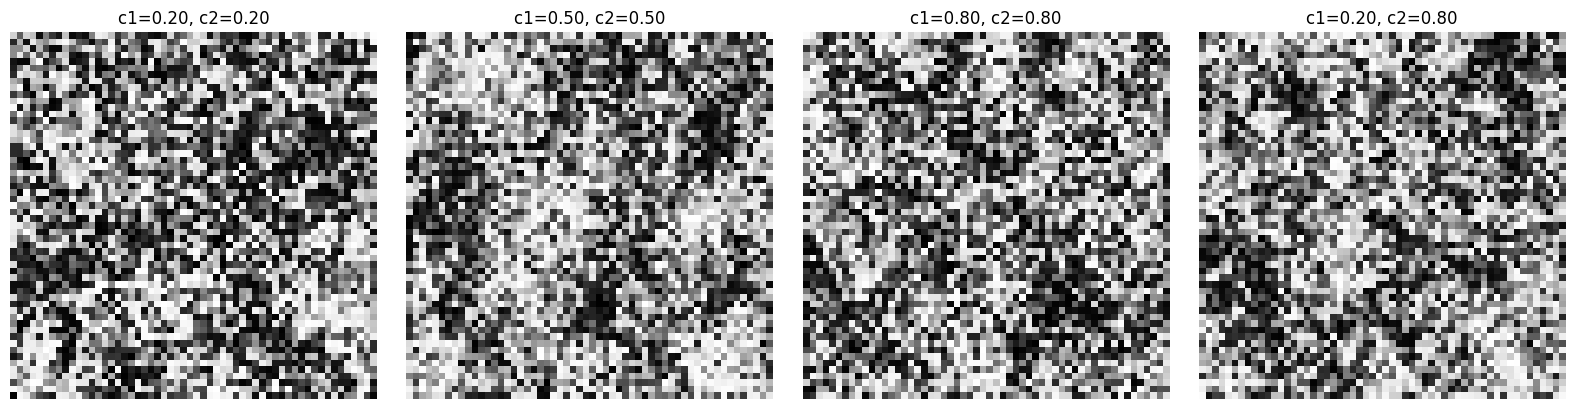

In [21]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torch

def sigmoid_filter(img, threshold=0.0, alpha=10.0):
    return torch.sigmoid(alpha * (img - threshold))

noise_scheduler.set_timesteps(num_inference_steps)

OUT_DIR = "./cDDIM_Generated_images"
os.makedirs(OUT_DIR, exist_ok=True)

test_conds = [
    (0.2, 0.2),
    (0.5, 0.5),
    (0.8, 0.8),
    (0.2, 0.8),
]

generated_imgs = []

print("Generating conditional samples...")
for k, (a, b) in enumerate(test_conds, 1):
    cond = torch.tensor([[a, b]], dtype=torch.float32, device=device)

    x = torch.randn((1, 1, IMG_H, IMG_W), device=device)
    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            pred_noise = c_unet(x, cond)
        x = noise_scheduler.step(pred_noise, t, x).prev_sample

    x = sigmoid_filter(x, threshold=0.0, alpha=10.0)

    path = os.path.join(OUT_DIR, f"cond_{k:02d}_c1_{a:.2f}_c2_{b:.2f}.png")
    save_image(x, path, normalize=True)

    generated_imgs.append((x.detach().cpu(), a, b))
    print(" saved:", path)

print("Done. Output folder:", OUT_DIR)

fig, axs = plt.subplots(1, len(generated_imgs), figsize=(4*len(generated_imgs), 4))

if len(generated_imgs) == 1:
    axs = [axs]

for ax, (img_tensor, a, b) in zip(axs, generated_imgs):
    img = img_tensor.squeeze().numpy()
    ax.imshow(img, cmap="gray")
    ax.set_title(f"c1={a:.2f}, c2={b:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

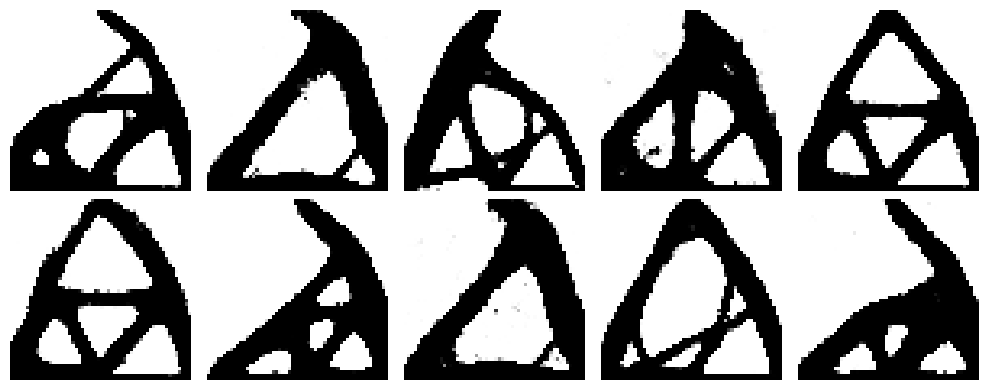

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from diffusers import DDIMScheduler

# ---- 모델 definition (minimal, matches your training code) ----
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor) -> torch.Tensor:
        device = time.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ConditionalResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_emb_dim: int, cond_emb_dim: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)

        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.cond_mlp = nn.Linear(cond_emb_dim, out_channels)

        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor, c_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(x)
        h = self.norm1(h)
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = h + self.cond_mlp(c_emb)[:, :, None, None]
        h = F.silu(h)

        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h)
        return h + self.residual_conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=256, cond_dim=2, cond_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, cond_emb_dim),
            nn.SiLU(),
            nn.Linear(cond_emb_dim, cond_emb_dim),
            nn.SiLU(),
            nn.Linear(cond_emb_dim, cond_emb_dim),
        )

        self.enc1 = ConditionalResBlock(in_channels, 64, time_emb_dim, cond_emb_dim)
        self.enc2 = ConditionalResBlock(64, 128, time_emb_dim, cond_emb_dim)
        self.enc3 = ConditionalResBlock(128, 256, time_emb_dim, cond_emb_dim)
        self.enc4 = ConditionalResBlock(256, 512, time_emb_dim, cond_emb_dim)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = ConditionalResBlock(512, 512, time_emb_dim, cond_emb_dim)

        self.up4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4 = ConditionalResBlock(1024, 256, time_emb_dim, cond_emb_dim)

        self.up3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec3 = ConditionalResBlock(512, 128, time_emb_dim, cond_emb_dim)

        self.up2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec2 = ConditionalResBlock(256, 64, time_emb_dim, cond_emb_dim)

        self.up1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1 = ConditionalResBlock(128, 64, time_emb_dim, cond_emb_dim)

        self.out_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x: torch.Tensor, timestep: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        t_emb = self.time_mlp(timestep.float())
        c_emb = self.cond_mlp(condition)

        e1 = self.enc1(x, t_emb, c_emb)
        e2 = self.enc2(self.pool(e1), t_emb, c_emb)
        e3 = self.enc3(self.pool(e2), t_emb, c_emb)
        e4 = self.enc4(self.pool(e3), t_emb, c_emb)

        b = self.bottleneck(self.pool(e4), t_emb, c_emb)

        d4 = self.up4(b)
        d4 = F.interpolate(d4, size=e4.shape[2:], mode="bilinear", align_corners=False)
        d4 = self.dec4(torch.cat([d4, e4], dim=1), t_emb, c_emb)

        d3 = self.up3(d4)
        d3 = F.interpolate(d3, size=e3.shape[2:], mode="bilinear", align_corners=False)
        d3 = self.dec3(torch.cat([d3, e3], dim=1), t_emb, c_emb)

        d2 = self.up2(d3)
        d2 = F.interpolate(d2, size=e2.shape[2:], mode="bilinear", align_corners=False)
        d2 = self.dec2(torch.cat([d2, e2], dim=1), t_emb, c_emb)

        d1 = self.up1(d2)
        d1 = F.interpolate(d1, size=e1.shape[2:], mode="bilinear", align_corners=False)
        d1 = self.dec1(torch.cat([d1, e1], dim=1), t_emb, c_emb)

        return self.out_conv(d1)

# ---- 불러오기 체크포인트 ----
ckpt = torch.load("Generator_cDDIM.pth", map_location=device)
state_dict = ckpt["model_state_dict"]
c1_min, c1_max = ckpt["c1_range"]
c2_min, c2_max = ckpt["c2_range"]

unet = ConditionalUNet(in_channels=1, out_channels=1, time_emb_dim=256, cond_dim=2, cond_emb_dim=128).to(device)
unet.load_state_dict(state_dict, strict=True)
unet.eval()

# ---- 스케줄러 & sampling ----
scheduler = DDIMScheduler(num_train_timesteps=600)
scheduler.set_timesteps(50)

def sigmoid_filter(img, threshold=0.0, alpha=10.0):
    return torch.sigmoid(alpha * (img - threshold))

batch_size = 10
# normalized condition in [0,1] (same condition for all images here)
cond = torch.tensor([[0.5, 0.5]] * batch_size, dtype=torch.float32, device=device)

x = torch.randn((batch_size, 1, 56, 56), device=device)
for t in scheduler.timesteps:
    ts = torch.full((batch_size,), t, device=device, dtype=torch.long)
    with torch.no_grad():
        eps = unet(x, ts, cond)
    x = scheduler.step(eps, t.long(), x).prev_sample

imgs = sigmoid_filter(x).detach().cpu().numpy()[:, 0]

# ---- Show ----
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()